### Import Libraries and Load Data

In [1]:
import pandas as pd
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine
import os
import math
import geopandas as gpd
import contextily as ctx
import random
import seaborn as sns

In [2]:
import os
import pandas as pd

cur_path = os.getcwd()
EVcoords_path = r"..\AustinAreabyCity\filtered_file_EV charger station.xlsx" # EV charger station data
Buscoords_path = "allbuscoords.csv" # Bus coordinates data
EV_optm_exi_path = r"..\df_chargers_existing_extended.csv" # planned EV existing in meters
EV_optm_new_path = r"..\df_chargers_newly_established.csv" # planned EV new in meters

BusData = pd.read_csv(Buscoords_path, index_col=None)
EVData = pd.read_excel(EVcoords_path, usecols=['Latitude', 'Longitude', 'Power', 'Occupancy', 'ChargerNumber'])
EVplanData1 = pd.read_csv(EV_optm_exi_path, index_col=None)
EVplanData2 = pd.read_csv(EV_optm_new_path, index_col=None)
# concatenate the two dataframes EVplanData1 and EVplanData2
EVplanData = pd.concat([EVplanData1, EVplanData2], ignore_index=True)


In [3]:
# Convert EV x,y coordinates to lat, long
gdf_ev = gpd.GeoDataFrame(
    EVplanData, geometry=gpd.points_from_xy(EVplanData.x_coord, EVplanData.y_coord), crs="EPSG:3857"
)
gdf_ev = gdf_ev.to_crs(epsg=4326)
EVplanData['Latitude'] = gdf_ev.geometry.y
EVplanData['Longitude'] = gdf_ev.geometry.x
EVplanData.head()


,charger,x_coord,y_coord,Latitude,Longitude
0,1021,-1.089018e+07,3.542711e+06,30.304187,-97.828187
1,1024,-1.089706e+07,3.535557e+06,30.248688,-97.889938
2,1027,-1.088725e+07,3.547998e+06,30.345187,-97.801813
3,1028,-1.090788e+07,3.544355e+06,30.316937,-97.987187
4,1030,-1.090243e+07,3.543146e+06,30.307562,-97.938187


### Derive Each Charger Capacity

In [4]:
x =EVData['Power']
p=[]
z = []
for xi in x[:10]:
    try:
        z.append(ast.literal_eval(xi))
    except (ValueError, SyntaxError):
        z.append(np.nan)
# z = [ast.literal_eval(xi) for xi in x]

for i,zi in enumerate(z):
    try:
        pi = [float(a.split()[1]) for a in zi]
        p.append(pi)
    except (ValueError,SyntaxError):
        p.append(np.nan)

In [5]:
n=[]
port_capacity = []
for row in x:
    try: 
        row = ast.literal_eval(row)
        row_result = []
        for item in row:
            if "/" in item:
                row_result.append(int(item.split("/")[1]))
            else:
                row_result.append(int(item))
        port_capacity.append(row_result)
    except (ValueError, SyntaxError):
        port_capacity.append(np.nan)

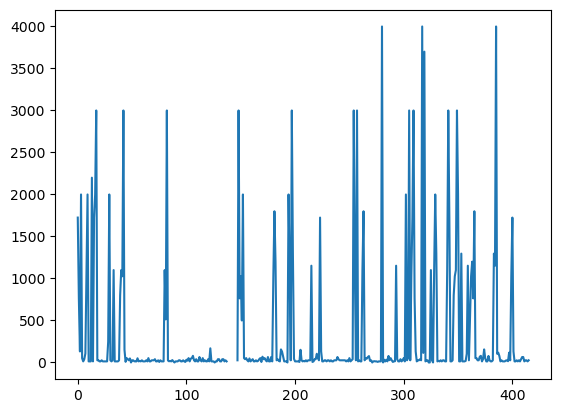

In [6]:
Pwr_data =EVData['Power']
Occ_data =EVData['Occupancy']
total_Pwr = []
for p, o in zip(Pwr_data,Occ_data):
    try: 
        pi = ast.literal_eval(p)
        oi = ast.literal_eval(o)
        oi_row_result = []
        pi_row_result = []
        for item in oi:
            if "/" in item:
                oi_row_result.append(int(item.split("/")[1]))
            else:
                oi_row_result.append(int(item))
                # print(oi_row_result)
        tmp = [float(a.split()[1]) for a in pi]
        pi_row_result.append(tmp)
        # print(pi_row_result)
        total_Pwr.append(np.sum(np.array(oi_row_result)*np.array(pi_row_result)))
    except (ValueError, SyntaxError):
        total_Pwr.append(np.nan)
plt.plot(range(len(total_Pwr)),total_Pwr)
EVData['total_Pwr'] = total_Pwr

In [7]:
from scipy.spatial import cKDTree
# function of finding the nearest bus stop to the EV charging stations
def nearest_bus(EVData, BusData):
    ev_coords = np.radians(EVData[['Latitude','Longitude']].to_numpy())
    bus_coords = np.radians(BusData[['Latitude','Longitude']].to_numpy())
    tree = cKDTree(bus_coords)
    distances,idxes = tree.query(ev_coords,k=1)
    EVData['NearestBus'] = BusData['Location'][idxes].values
    return EVData

# find the nearest bus stop to the EV charging stations
EVData = nearest_bus(EVData, BusData)
EVData = EVData.dropna(subset=['total_Pwr'])
EVData = EVData[EVData['total_Pwr'] > 0]

EVplanData = nearest_bus(EVplanData, BusData)



In [8]:
print(len(EVData))
print(len(EVData['NearestBus'].unique()))
EVData.head()

398
238


,Latitude,Longitude,Power,Occupancy,ChargerNumber,total_Pwr,NearestBus
0,30.266813,-97.754063,"['· 125 kW', '· 125 kW', '· 62.5 kW', '· 62.5 ...","['1/6', '0/6', '1', '0/1', '0/1', '0/1']",16.0,1725.00,p5ulv13156
1,30.264187,-97.733937,"['· 125 kW', '· 125 kW', '· 62.5 kW', '· 62.5 ...","['0/2', '2', '0/2', '0/2', '2/2']",10.0,762.96,p5udm18350
2,30.271187,-97.745312,"['· 62.5 kW', '· 62.5 kW', '· 6.48 kW']","['0/1', '1', '1/1']",3.0,131.48,p5udt33622
3,30.247188,-97.750062,['· 250 kW'],['8'],8.0,2000.00,p5udm3632
4,30.266188,-97.751688,['· 6.48 kW'],['8/8'],8.0,51.84,p5udm4106


### Add EV in Single Grid Network

In [9]:
import opendssdirect as dss
os.chdir(cur_path)
# master_file_path = r"D:\AUS\P5U\scenarios\base_timeseries\opendss_no_loadshapes\Master.dss"
master_file_path = r"AUS\P1R\base_timeseries\opendss_no_loadshapes\Master.dss"
dss.Command(f"compile {master_file_path}")
dss.Solution.Solve()
print(dss.Solution.Converged())
# os.chdir(cur_path)

True


In [10]:
# Helper function to check if a load exists
def load_exists(load_name):
    try:
        dss.Loads.Name(load_name)  # Try setting the load active
        return dss.Loads.Name().lower() == load_name.lower()  # Confirm match
    except:
        return False

In [11]:
def plot_bus_voltage(bus_names):
    vpu_allbus = {}
    for k, a in enumerate(bus_names):
        dss.Circuit.SetActiveBus(a)
        n = dss.Bus.Nodes()
        v = dss.Bus.puVmagAngle()
        vmag = [v[i] for i in range(0, len(v), 2)]
        vmag = [v for i, v in enumerate(vmag) if vmag[i] != 0]
        if vmag:
            vmin = min(vmag)
            vpu_allbus[a] = vmin
    print(f"min v: {min(list(vpu_allbus.values()))}")
    plt.plot(vpu_allbus.values())
    plt.xlabel('Bus Index')
    plt.ylabel('Voltage (p.u.)')
    plt.title('Bus Voltage Profile')
    plt.show()

In [12]:
def distribute_ev_loads_to_buses(EVData, BusData, k=1):
    ev_coords = np.radians(EVData[['Latitude', 'Longitude']].to_numpy())
    bus_coords = np.radians(BusData[['Latitude', 'Longitude']].to_numpy())
    tree = cKDTree(bus_coords)
    distances, indices = tree.query(ev_coords, k=k)
    
    distributed_loads = {}
    for ev_idx, (dist_list, idx_list) in enumerate(zip(distances, indices)):
        ev_power = EVData.iloc[ev_idx]['total_Pwr']
        if np.isscalar(dist_list):#isinstance(dist_list, (np.float64, float)):
            dist_list = [dist_list]
            idx_list = [idx_list]
        num_buses = min(len(idx_list), k)
        for _, bus_idx in zip(dist_list, idx_list):
            bus = BusData.iloc[bus_idx]['Bus']
            distributed_loads[bus] = ev_power / num_buses + distributed_loads.get(bus, 0)
    
    distributed_loads_df = pd.DataFrame(list(distributed_loads.items()), columns=['NearestBus', 'total_Pwr'])
    return distributed_loads_df



bus_names = dss.Circuit.AllBusNames()
EVData_Regional = EVData[EVData['NearestBus'].isin(bus_names)]
# Read the regional bus coordinates
bus_coords_path = r"D:\AUS\P1R\scenarios\base_timeseries\opendss_no_loadshapes\Buscoords.dss"
BusData_Regional = pd.read_csv(bus_coords_path, sep='\s+', names=['Bus', 'X', 'Y'])
# Replace x, y coordinates with latitude and longitude
BusData_Regional['Latitude'] = BusData_Regional['Y']
BusData_Regional['Longitude'] = BusData_Regional['X']
distributed_loads_df = distribute_ev_loads_to_buses(EVData_Regional, BusData_Regional, k=20000)
# make a switch to compute EV_bus based on the two methods below
method = 2  # Set this to 1 or 2 to choose the method

if method == 1:
    EVData_Regional = EVData[EVData['NearestBus'].isin(bus_names)]
    EV_bus = EVData_Regional.groupby('NearestBus')['total_Pwr'].sum().reset_index()
else:
    EVData_Regional = distributed_loads_df[distributed_loads_df['NearestBus'].isin(bus_names)]
    EV_bus = EVData_Regional


sum(EV_bus['total_Pwr'])

15086.915902998106

True
min v: 0.6784377819914754


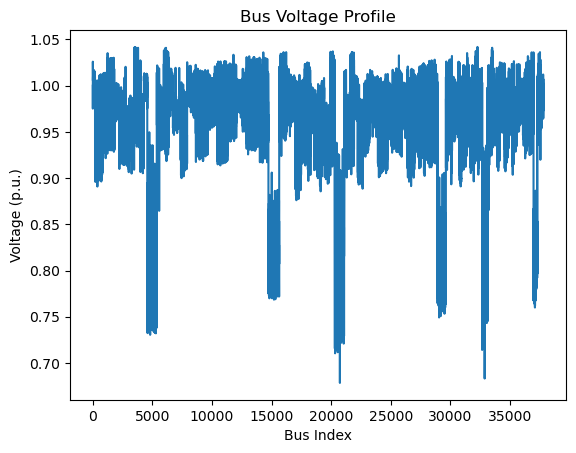

In [13]:
# # defining the bus names based on opendss circuit
# bus_names = dss.Circuit.AllBusNames()
# EVData_Regional = EVData[EVData['NearestBus'].isin(bus_names)]
# EV_bus = EVData_Regional.groupby('NearestBus')['total_Pwr'].sum().reset_index()
def distribute_ev_loads(EV_bus):
    for _, row in EV_bus.iterrows():
        bus = row['NearestBus']
        power = row['total_Pwr']
        dss.Circuit.SetActiveBus(bus)
        kv = dss.Bus.kVBase() * math.sqrt(3)
        load_name = f"EV_{bus}"
        if power > 0:
            if load_exists(load_name):
                dss.Text.Command(f"Edit Load.{load_name} Bus1={bus} kW={power} Phases=3 kV={kv} Model=1")
                # print(2)
            else:
                dss.Text.Command(f"New Load.{load_name} Bus1={bus} kW={power} Phases=3 kV={kv} Model=1")
                # print(1) 
    dss.Solution.Solve()
    print(dss.Solution.Converged())

distribute_ev_loads(EV_bus)
plot_bus_voltage(bus_names)


## Edit and New, you have to make sure and apply correctly

In [14]:
bus_names = dss.Circuit.AllBusNames()
EVplanData_Regional = EVplanData[EVplanData['NearestBus'].isin(bus_names)]

for _,row in EVplanData_Regional.iterrows():
    bus = row['NearestBus']
    power = 600 #row['total_Pwr']
    load_name = f"EVplan_{bus}"
    dss.Circuit.SetActiveBus(bus)
    kv = dss.Bus.kVBase()*math.sqrt(3)
    if power > 0:
        if load_exists(load_name):
            dss.Text.Command(f"Edit Load.{load_name} Bus1={bus} kW={power} Phases=3 kV={kv} Model=1")
            # print(2)
        else:
            dss.Text.Command(f"New Load.{load_name} Bus1={bus} kW={power} Phases=3 kV={kv} Model=1")
            # print(1)
        
# dss.Text.Command("Solve")    
dss.Solution.Solve()
print(dss.Solution.Converged())


True


True
Total Hosting Capacity: 2268.917070777815 kW


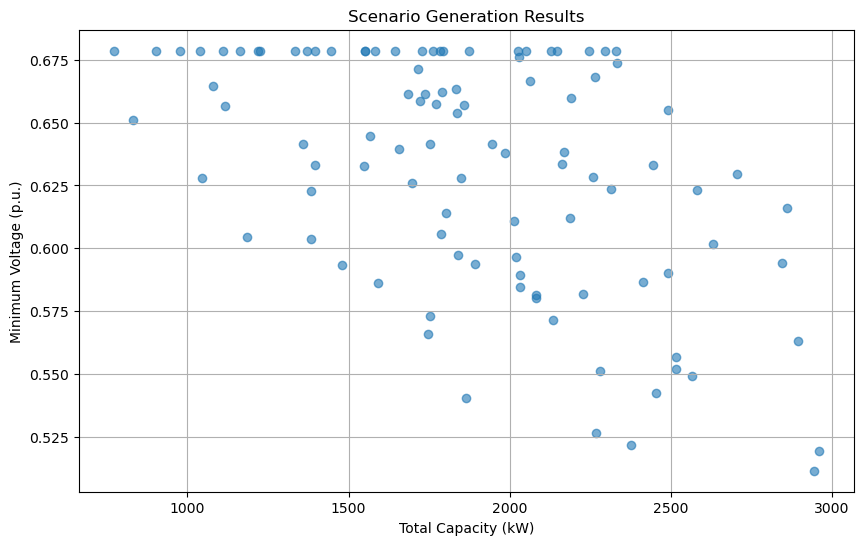

In [ ]:
# Function to generate biased random capacities (Truncated Normal)
def generate_random_capacity(mean, std, lower, upper):
    while True:
        value = random.gauss(mean, std)  # Generate from normal distribution
        if lower <= value <= upper:  # Ensure within bounds
            return value

# Check convergence
print(dss.Solution.Converged())

# Get all bus names in the current region
bus_names = dss.Circuit.AllBusNames()

# Scenario generation to find the total hosting capacity
num_scenarios = 100
scenario_results = []

for _ in range(num_scenarios):
    scenario_capacity = []
    # Randomly set the capacity for all buses in EVplanData
    for idx, row in EVplanData_Regional.iterrows():
        bus = row['NearestBus']
        dss.Circuit.SetActiveBus(bus)
        kv = dss.Bus.kVBase() * math.sqrt(3)
        random_capacity = generate_random_capacity(mean=100, std=300, lower=1, upper=1000)
        load_name = f"EVplan_{bus}"
        if random_capacity > 0:
            if load_exists(load_name):
                dss.Text.Command(f"Edit Load.{load_name} Bus1={bus} kW={random_capacity} Phases=3 kV={kv} Model=1")
            else:
                dss.Text.Command(f"New Load.{load_name} Bus1={bus} kW={random_capacity} Phases=3 kV={kv} Model=1")
        scenario_capacity.append(random_capacity)
    dss.Solution.Solve()
    
    # Check the overall bus voltages
    vpu_allbus = {}
    for bus in bus_names:
        dss.Circuit.SetActiveBus(bus)
        v = dss.Bus.puVmagAngle()
        vmag = [v[i] for i in range(0, len(v), 2)]
        vmag = [v for v in vmag if v != 0]
        if vmag:
            vpu_allbus[bus] = min(vmag)
    
    # Find the threshold of Vmin
    vmin_threshold = min(vpu_allbus.values())
    scenario_results.append((sum(scenario_capacity), vmin_threshold))

# Calculate the total hosting capacity
total_hosting_capacity = sum(scenario_capacity)
print(f"Total Hosting Capacity: {total_hosting_capacity} kW")

# Plot the results
capacities, vmins = zip(*scenario_results)
plt.figure(figsize=(10, 6))
plt.scatter(capacities, vmins, alpha=0.6)
plt.xlabel('Total Capacity (kW)')
plt.ylabel('Minimum Voltage (p.u.)')
plt.title('Scenario Generation Results')
plt.grid(True)
plt.savefig('scenario_generation_results_P1R.png')
plt.show()

# Save capacities and vmins to a file for the P1R circuit
output_data = pd.DataFrame({'Total Capacity (kW)': capacities, 'Minimum Voltage (p.u.)': vmins})
output_data.to_csv('P1R_scenario_generation_results.csv', index=False)

In [26]:
# # find EVplanData that are in the same region as the buses
# EVplanData_Regional = EVplanData[EVplanData['NearestBus'].isin(bus_names)]
# # run hosting capacity on buses that EV load were assigned
# hosting_capacity = {}
# step = 1000

# for idx, row in EV_bus.iterrows():
#     print(idx)
#     bus = row['NearestBus']
#     power = row['total_Pwr']
#     dss.Circuit.SetActiveBus(bus)
#     kv = dss.Bus.kVBase() * math.sqrt(3)
#     initial_power = 1000
#     while True:
#         dss.Text.Command(f"Edit Load.{bus} kW={initial_power}")
#         dss.Solution.Solve()
#         v = dss.Bus.puVmagAngle()

#         vmag = [v[i] for i in range(0, len(v), 2)]
#         n = dss.Bus.Nodes()
#         vmag = vmag[:len(n)]
#         # remove the zero sequence voltage
#         vmag = [v for i, v in enumerate(vmag) if vmag[i] != 0]
#         # print(vmag)
#         if min(vmag) < 0.8:
            
#             break
#         if not dss.Solution.Converged():
#             break
#         initial_power += step
#     hosting_capacity[bus] = initial_power - step

# print(hosting_capacity)



### <span style="color:lightblue"> Add EV in looped Grid Networks</span>

In [33]:
import opendssdirect as dss
AusGridPath = r"D:\AUS"
masterpath = r"scenarios\base_timeseries\opendss_no_loadshapes\Master.dss"
buscoords_path = r"scenarios\base_timeseries\opendss_no_loadshapes\Buscoords.dss"

def compile_dss_files(AusGridPath, masterpath, buscoords_path):
    subGridPath = os.listdir(AusGridPath)
    MasterPaths = [
        os.path.join(AusGridPath, a, masterpath)
        for a in subGridPath
    ]
    BusPaths = [
        os.path.join(AusGridPath, a, buscoords_path)
        for a in subGridPath
    ]
    return MasterPaths, BusPaths

MasterPaths, BusPaths = compile_dss_files(AusGridPath, masterpath, buscoords_path)



['D:\\AUS\\P1R\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss',
 'D:\\AUS\\P1U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss',
 'D:\\AUS\\P2U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss',
 'D:\\AUS\\P3U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss',
 'D:\\AUS\\P4U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss',
 'D:\\AUS\\P5U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss']

### <span style="color:gold">Plot Buses </span>
Plot Grid by Region (paper figure)

In [16]:
def plotGridNetworks(BusPaths):
    busdata = []
    geo_df =[]
    for buspath in BusPaths:
        data = pd.read_csv(buspath, sep='\s+', names = ['Bus','X','Y'])
        busdata.append(data)
    bus_coords_all = pd.concat(busdata, ignore_index=True)
    for i in busdata:
        gdf_bus = gpd.GeoDataFrame(
        i,
        geometry=gpd.points_from_xy(i['X'],i['Y']),
        crs="EPSG:4326")
        gdf_bus = gdf_bus.to_crs(epsg=3857)
        geo_df.append(gdf_bus)
    
    # colors = [f'#{random.randint(0,0xFFFFFF):06x}' for _ in geo_df]
    colors = sns.color_palette("Set2", n_colors=len(geo_df))
    fig,ax = plt.subplots(figsize = (10,8))
    for i,c,r in zip(geo_df,colors,subGridPath):
        i.plot(ax = ax,color = c,marker = 'o',markersize = 4,alpha = 0.8,label = r)
    ctx.add_basemap(ax,source =ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.savefig(
        r"C:\Users\jingb\Box\Reserach\01_V2G\EVCharger_SharedFolder\Journal Extension-PESGM_Codes_2024\Figures\GridPlots.png",
        format = 'png',dpi = 300
    )
    plt.show()
# plotGridNetworks(BusPaths)

### <span style="color:gold">Plot MinV by Region </span>
Plot Grid by Region (paper figure)

In [17]:
vpu_by_region =[]
vpu_allbus_o ={}
colors = sns.color_palette("Set2", n_colors=len(MasterPaths))
# fig, ax = plt.subplots(figsize=(12, 10)) 
for m in MasterPaths[:0]:
    master_file_path = m
    dss.Command(f"compile {master_file_path}")
    dss.Solution.Solve()
    print(dss.Solution.Converged())
    bus_names = dss.Circuit.AllBusNames()
    vpu_allbus_o_region ={}
    for k,a in enumerate(bus_names):
        x = dss.Circuit.SetActiveBus(a)
        n = dss.Bus.Nodes()
        v = dss.Bus.puVmagAngle()
        # vmag = [v[i] for i in [(nn-1)*2 for nn in range(len(n))] ]
        # vmag = [v[i] for nn in range(len(n)) for i in [(nn-1)*2] if v[i]>0] # this is correct code!!
        vmag = []
        for nn in range(len(n)):
            i = nn*2
            if v[i] >0:
                vmag.append(v[i])            
        if vmag:
            vmin = min(vmag)
            vpu_allbus_o_region[a] = vmin
            vpu_allbus_o[a] = vmin
    vpu_by_region.append(vpu_allbus_o_region)
    print(f"min v: {min(list(vpu_allbus_o_region.values()))}")

In [18]:
os.chdir(cur_path)
master_file_path = MasterPaths# m
dss.Command(f"compile {master_file_path}")

bus_names = dss.Circuit.AllBusNames()
EVData_Regional = EVData[EVData['NearestBus'].isin(bus_names)]
EV_bus = EVData_Regional.groupby('NearestBus')['total_Pwr'].sum().reset_index()*(1)
for _,row in EV_bus.iterrows():
    
    bus = row['NearestBus']
    power = row['total_Pwr']
    dss.Circuit.SetActiveBus(bus)
    kv = dss.Bus.kVBase()*math.sqrt(3)
    if power>0:
        dss.Text.Command(f"New Load.EV_{bus} Bus1={bus} kW={power} kV={kv} Phases=3 Model=1")

dss.Solution.Solve()
print(dss.Solution.Converged())
for _,row in EV_bus.iterrows():
        bus = row['NearestBus']
        power = row['total_Pwr']
        dss.Circuit.SetActiveBus(bus)
        kv = dss.Bus.kVBase()*math.sqrt(3)
        v = dss.Bus.puVmagAngle()
        # print(v)
for k,a in enumerate(bus_names):
    x = dss.Circuit.SetActiveBus(a)
    n = dss.Bus.Nodes()
    v = dss.Bus.puVmagAngle()
    # vmag = [v[i] for i in [(nn-1)*2 for nn in range(len(n))] ]
    # vmag = [v[i] for nn in range(len(n)) for i in [(nn-1)*2] if v[i]>0] # this is correct code!!
    vmag = []
    for nn in range(len(n)):
        i = nn*2
        if v[i] >0:
            vmag.append(v[i])            
    if vmag:
        vmin = min(vmag)
        vpu_allbus[a] = vmin
print(f"min v: {min(list(vpu_allbus.values()))}")

DSSException: (#243) Redirect file not found: "'D:\\AUS\\P1R\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss', 'D:\\AUS\\P1U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss', 'D:\\AUS\\P2U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss', 'D:\\AUS\\P3U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss', 'D:\\AUS\\P4U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss', 'D:\\AUS\\P5U\\scenarios\\base_timeseries\\opendss_no_loadshapes\\Master.dss'"

In [78]:
vpu_allbus ={}
for m in MasterPaths[:0]:
    master_file_path = MasterPaths# m
    dss.Command(f"compile {master_file_path}")
    
    bus_names = dss.Circuit.AllBusNames()
    EVData_Regional = EVData[EVData['NearestBus'].isin(bus_names)]
    EV_bus = EVData_Regional.groupby('NearestBus')['total_Pwr'].sum().reset_index()*(1)
    for _,row in EV_bus.iterrows():
        
        bus = row['NearestBus']
        power = row['total_Pwr']
        dss.Circuit.SetActiveBus(bus)
        kv = dss.Bus.kVBase()*math.sqrt(3)
        if power>0:
            dss.Text.Command(f"New Load.EV_{bus} Bus1={bus} kW={power} kV={kv} Phases=3 Model=1")
    
    dss.Solution.Solve()
    print(dss.Solution.Converged())
    for _,row in EV_bus.iterrows():
        bus = row['NearestBus']
        power = row['total_Pwr']
        dss.Circuit.SetActiveBus(bus)
        kv = dss.Bus.kVBase()*math.sqrt(3)
        v = dss.Bus.puVmagAngle()
        # print(v)
    for k,a in enumerate(bus_names):
        x = dss.Circuit.SetActiveBus(a)
        n = dss.Bus.Nodes()
        v = dss.Bus.puVmagAngle()
        # vmag = [v[i] for i in [(nn-1)*2 for nn in range(len(n))] ]
        # vmag = [v[i] for nn in range(len(n)) for i in [(nn-1)*2] if v[i]>0] # this is correct code!!
        vmag = []
        for nn in range(len(n)):
            i = nn*2
            if v[i] >0:
                vmag.append(v[i])            
        if vmag:
            vmin = min(vmag)
            vpu_allbus[a] = vmin
    print(f"min v: {min(list(vpu_allbus.values()))}")

In [83]:
a = (np.array(list(vpu_allbus.values()))-np.array(list(vpu_allbus_o.values())))
plt.plot(np.array(list(vpu_allbus.values())))
plt.plot(np.array(list(vpu_allbus_o.values())))
plt.xlabel('Bus Index')

ValueError: operands could not be broadcast together with shapes (37822,) (0,) 

### <span style="color:salmon;">Reassign EV location to Buses (based on radius)</span>


True
Total Hosting Capacity for region 62: 1756.9950808161595 kW


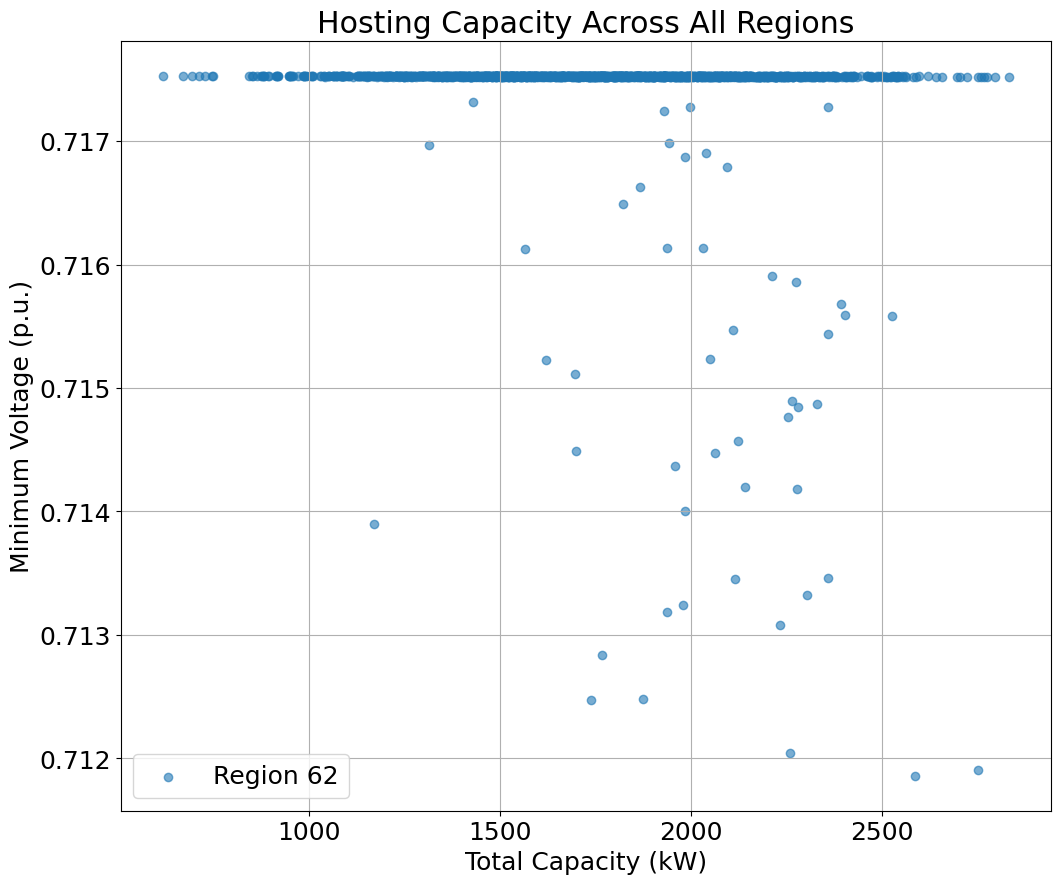

In [94]:
def check_overall_bus_voltages(bus_names):
    vpu_allbus = {}
    for bus in bus_names:
        dss.Circuit.SetActiveBus(bus)
        v = dss.Bus.puVmagAngle()
        vmag = [v[i] for i in range(0, len(v), 2)]
        n = dss.Bus.Nodes()
        vmag = vmag[:len(n)]
        vmag = [v for i, v in enumerate(vmag) if vmag[i] != 0]
        if vmag:
            vpu_allbus[bus] = min(vmag)
    
    # Find the threshold of Vmin
    vmin_threshold = min(vpu_allbus.values())
    return vpu_allbus, vmin_threshold

# Initialize the dictionary for all bus voltage data
# Filter out the buses of EVPlanData for each network


# Initialize the dictionary for all bus voltage data
vpu_allbus_o = {}

# Create a single figure for all regions
fig, ax = plt.subplots(figsize=(12, 10))


# Iterate through each master file path for the looped network
# only run a single network for now
MasterPaths, BusPaths = compile_dss_files(AusGridPath, masterpath, buscoords_path)
MasterPaths = MasterPaths[0:1]
for idx, master_file_path in enumerate(MasterPaths):
    # Compile the DSS file
    dss.Command(f"compile {master_file_path}")
    dss.Solution.Solve()

    # Check convergence
    print(dss.Solution.Converged())

    # defining the bus names based on opendss circuit
    bus_names = dss.Circuit.AllBusNames()
    _, base_vmin_threshold = check_overall_bus_voltages(bus_names)
    
    # Scenario generation to find the total hosting capacity
    num_scenarios = 1500
    total_capacity = []
    scenario_results = []
    EVplanData_Regional = EVplanData[EVplanData['NearestBus'].isin(bus_names)]
    for _ in range(num_scenarios):
        scenario_capacity = []
        # Randomly set the capacity for all buses in EVplanData
        for idx, row in EVplanData_Regional.iterrows():
            bus = row['NearestBus']
            dss.Circuit.SetActiveBus(bus)
            kv = dss.Bus.kVBase() * math.sqrt(3)
            random_capacity = random.uniform(1, 500)  # Random capacity between 1 kW and 1000 kW
            if random_capacity > 0:
                if load_exists(load_name):
                    dss.Text.Command(f"Edit Load.{load_name} Bus1={bus} kW={random_capacity} Phases=3 kV={kv} Model=1")
                else:
                    dss.Text.Command(f"New Load.{load_name} Bus1={bus} kW={random_capacity} Phases=3 kV={kv} Model=1")
            scenario_capacity.append(random_capacity)  
        dss.Solution.Solve()
        
        # Check the overall bus voltages
        _, vmin_threshold = check_overall_bus_voltages(bus_names)
        total_capacity.append(sum(scenario_capacity))
        scenario_results.append((sum(scenario_capacity), vmin_threshold))

    # Calculate the total hosting capacity
    total_hosting_capacity = sum(total_capacity) / len(total_capacity) if total_capacity else 0
    print(f"Total Hosting Capacity for region {idx + 1}: {total_hosting_capacity} kW")

    # Plot the results
    capacities, vmins = zip(*scenario_results)
    ax.scatter(capacities, vmins, alpha=0.6, label=f'Region {idx + 1}')
    # Save capacities and vmins to CSV for each grid region
    output_df = pd.DataFrame({'Capacity': capacities, 'Vmin': vmins})
    output_df.to_csv(f'region_{idx + 1}_capacities_vmins.csv', index=False)

# Add legend, labels, and title
ax.legend(loc='best')
ax.set_title("Hosting Capacity Across All Regions")
ax.set_xlabel("Total Capacity (kW)")
ax.set_ylabel("Minimum Voltage (p.u.)")
ax.grid(True)

# Show the final plot
plt.show()



In [92]:
vmins

(0.7175237446090545,
 0.7175219109355253,
 0.7175244499956205,
 0.7175262723923678,
 0.7175254145501453,
 0.7175290562003733,
 0.7175249972751495,
 0.7175245577636854,
 0.7175271147282821,
 0.7175249488472235,
 0.7175212559328741,
 0.7175274736232787,
 0.7175277540513582,
 0.7175236270998733,
 0.717522294474207)

In [73]:
import os

directory = os.path.join(cur_path, "GridIntegration", "HostingCapacityV1")
directory

'c:\\Users\\jingb\\Box\\Reserach\\01_V2G\\EVCharger_SharedFolder\\Journal Extension-PESGM_Codes_2024\\GridIntegration\\GridIntegration\\HostingCapacityV1'

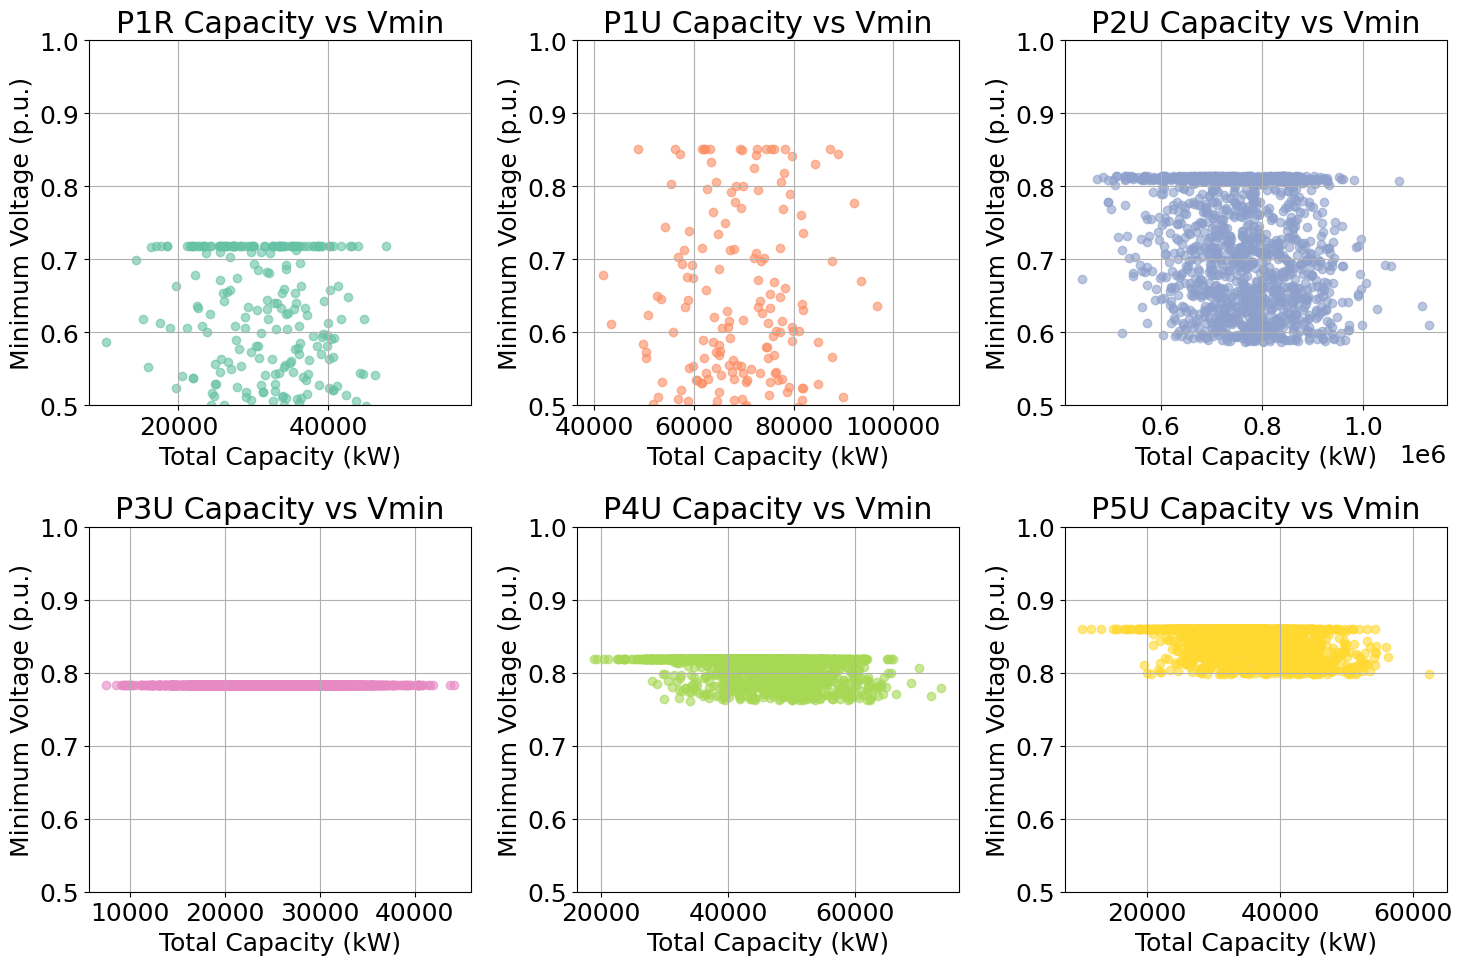

In [82]:

import pandas as pd
import os
import seaborn as sns

import matplotlib.pyplot as plt

# Directory containing the CSV files
cur_path
directory = os.path.join(cur_path,  "HostingCapacityV1")

# List all CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Create a 2x3 subplot

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# set all font size to 18
plt.rcParams.update({'font.size': 18})

# Flatten the axes array for easy iteration
axes = axes.flatten()
for ax in axes:
    ax.set_ylim(0.5, 1)
# Iterate over the CSV files and plot each one

# Generate a color palette for the regions
colors = sns.color_palette("Set2", n_colors=len(csv_files))

# Iterate over the CSV files and plot each one with the corresponding color
for i, (csv_file, color) in enumerate(zip(csv_files, colors)):
    # Read the CSV file
    df = pd.read_csv(os.path.join(directory, csv_file))
    
    # Plot the data
    axes[i].scatter(df['Capacity'], df['Vmin'], alpha=0.6, color=color)
    # set the title to the second part of after "_"
    axes[i].set_title(csv_file.split("_")[1]+' Capacity vs Vmin')
    
    axes[i].set_xlabel('Total Capacity (kW)')
    axes[i].set_ylabel('Minimum Voltage (p.u.)')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
# Save the plot
plt.savefig(os.path.join(directory, 'hosting_capacity_results.pdf'), format='pdf')
plt.show()

True
True
Total Hosting Capacity for region 62: 3138.4034186279723 kW
True
True
Total Hosting Capacity for region 61: 7552.972511333273 kW
True
True
Total Hosting Capacity for region 47: 10444.340109615407 kW
True
True
Total Hosting Capacity for region 57: 2371.968118044652 kW
True
True
Total Hosting Capacity for region 58: 5080.45899025541 kW
True
True
Total Hosting Capacity for region 43: 3591.5280316261624 kW


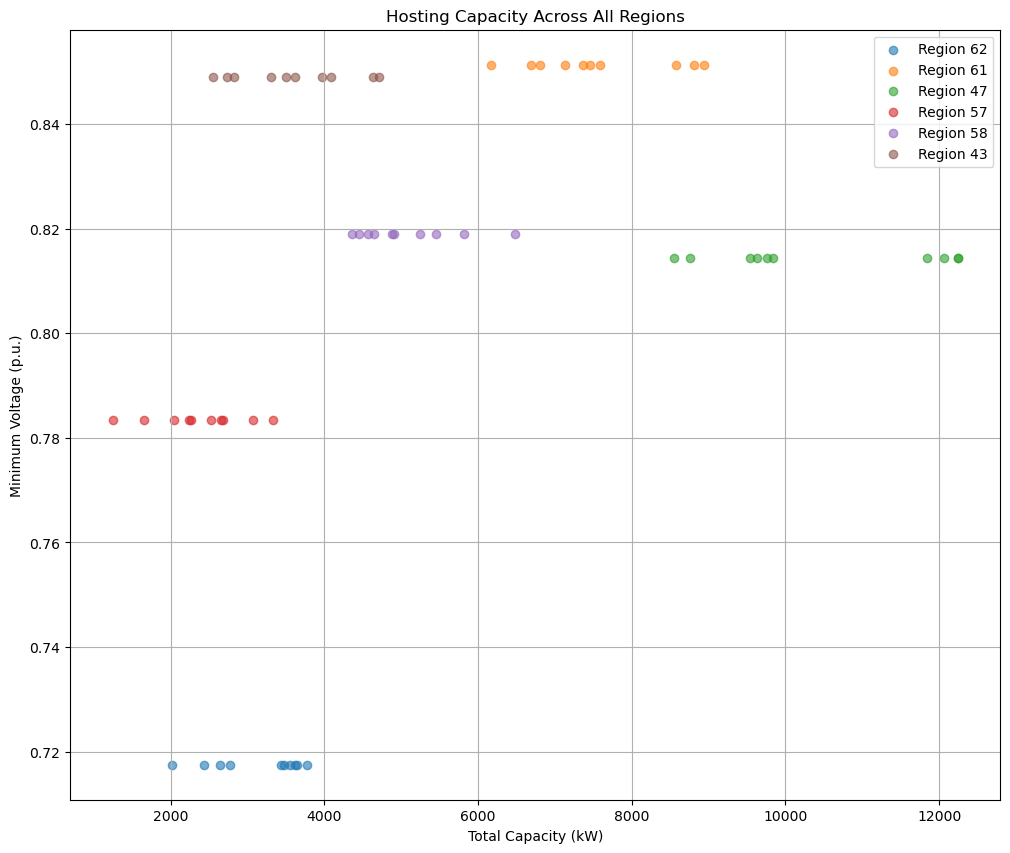

In [ ]:
# Initialize the dictionary for all bus voltage data
# Filter out the buses of EVPlanData for each network


# Initialize the dictionary for all bus voltage data
vpu_allbus_o = {}

# Create a single figure for all regions
fig, ax = plt.subplots(figsize=(12, 10))


# Iterate through each master file path for the looped network
for idx, master_file_path in enumerate(MasterPaths):
    # Compile the DSS file
    dss.Command(f"compile {master_file_path}")
    dss.Solution.Solve()

    # Check convergence
    print(dss.Solution.Converged())

    # defining the bus names based on opendss circuit
    bus_names = dss.Circuit.AllBusNames()
    EVData_Regional = EVData[EVData['NearestBus'].isin(bus_names)]
    EV_bus = EVData_Regional.groupby('NearestBus')['total_Pwr'].sum().reset_index()

    # adding the EV load to the buses
    for _,row in EV_bus.iterrows():
        bus = row['NearestBus']
        power = row['total_Pwr']
        dss.Text.Command(f"New Load.{bus} Bus1={bus} kW={power} Phases=3 kV=11 Model=1")
    # dss.Text.Command("Solve")    
    dss.Solution.Solve()
    print(dss.Solution.Converged())


    region_vpu = []
    region_vpu_EV = []
    for k, a in enumerate(bus_names):
        x = dss.Circuit.SetActiveBus(a)
        n = dss.Bus.Nodes()
        v = dss.Bus.puVmagAngle()

        # Extract per-unit voltage magnitudes
        vmag = []
        for nn in range(len(n)):
            i = nn * 2
            if v[i] > 0:
                vmag.append(v[i])
        if vmag:
            vmin = min(vmag)
            vpu_allbus_o[a] = vmin
            region_vpu.append(vmin)
    
    # Scenario generation to find the total hosting capacity
    num_scenarios = 10
    total_capacity = []
    scenario_results = []
    EVplanData_Regional = EVplanData[EVplanData['NearestBus'].isin(bus_names)]
    for _ in range(num_scenarios):
        scenario_capacity = []
        # Randomly set the capacity for all buses in EVplanData
        for idx, row in EVplanData_Regional.iterrows():
            bus = row['NearestBus']
            dss.Circuit.SetActiveBus(bus)
            kv = dss.Bus.kVBase() * math.sqrt(3)
            random_capacity = random.uniform(1, 1000)  # Random capacity between 1 kW and 1000 kW
            if random_capacity > 0:
                dss.Text.Command(f"Edit Load.EVplan_{bus} Bus1={bus} kW={random_capacity} kV={kv} Phases=3 Model=1")
            scenario_capacity.append(random_capacity)
        
        dss.Solution.Solve()
        
        # Check the overall bus voltages
        vpu_allbus = {}
        for bus in bus_names:
            dss.Circuit.SetActiveBus(bus)
            v = dss.Bus.puVmagAngle()
            vmag = [v[i] for i in range(0, len(v), 2)]
            n = dss.Bus.Nodes()
            vmag = vmag[:len(n)]
            vmag = [v for i, v in enumerate(vmag) if vmag[i] != 0]
            if vmag:
                vpu_allbus[bus] = min(vmag)
        
        # Find the threshold of Vmin
        vmin_threshold = min(vpu_allbus.values())
        total_capacity.append(sum(scenario_capacity))
        scenario_results.append((sum(scenario_capacity), vmin_threshold))

    # Calculate the total hosting capacity
    total_hosting_capacity = sum(total_capacity) / len(total_capacity) if total_capacity else 0
    print(f"Total Hosting Capacity for region {idx + 1}: {total_hosting_capacity} kW")

    # Plot the results
    capacities, vmins = zip(*scenario_results)
    ax.scatter(capacities, vmins, alpha=0.6, label=f'Region {idx + 1}')

# Add legend, labels, and title
ax.legend(loc='best')
ax.set_title("Hosting Capacity Across All Regions")
ax.set_xlabel("Total Capacity (kW)")
ax.set_ylabel("Minimum Voltage (p.u.)")
ax.grid(True)

# Show the final plot
plt.show()

In [84]:
ev_coords = np.radians(EVData[['Latitude','Longitude']].to_numpy())
bus_coords = np.radians(BusData[['Latitude','Longitude']].to_numpy())
tree = cKDTree(bus_coords)
k = 10
distances, indices = tree.query(ev_coords, k=k)

In [85]:
distributed_loads ={}
for ev_idx,(dist_list, idx_list) in enumerate(zip(distances, indices)):
    ev_power = EVData.iloc[ev_idx]['total_Pwr']
    if isinstance(dist_list,(np.float64,float)):
        dist_list = [dist_list]
        idx_list = [idx_list]
    for _,bus_idx in zip(dist_list,idx_list):
        bus = BusData.iloc[bus_idx]['Location']
        distributed_loads[bus] = ev_power/len(dist_list) + distributed_loads.get(bus,0)
distributed_loads_df = pd.DataFrame(list(distributed_loads.items()),columns=['Nearest_Buses','total_Pwr'])

In [86]:
print(len(distributed_loads_df))
print(len(ev_coords))
print(max(distributed_loads_df['total_Pwr'])/1000
      ,np.sum(distributed_loads_df['total_Pwr'])/1000)

2286
416
1.5964480000000003 115.48363400000002


DSSException: (#242) Redirect file not found: "A"

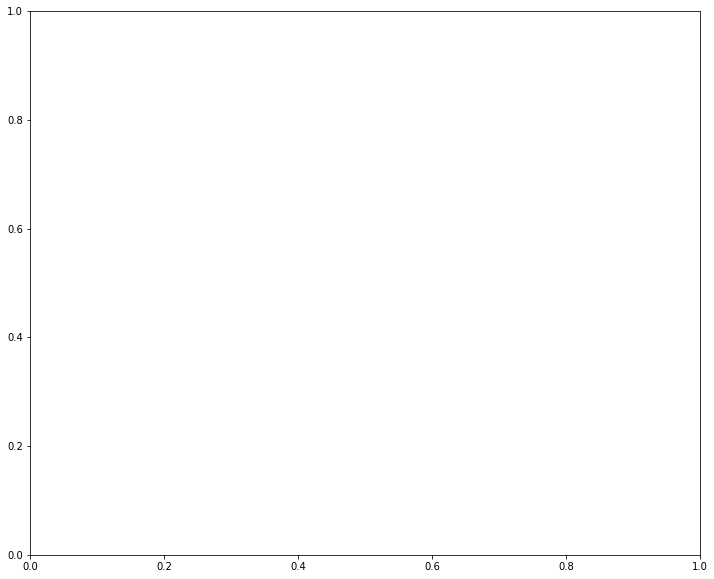

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors

os.chdir(cur_path)
def adjust_color(color, amount = 0.5):
    c = mcolors.to_rgba(color)
    return (min(1,max(0,c[0]*amount)), min(1,max(0,c[1]*amount)), min(1,max(0,c[2]*amount)),c[3])
# Generate a color palette for the regions
colors = sns.color_palette("Set2", n_colors=len(MasterPaths)*2)

# Initialize the dictionary for all bus voltage data
vpu_allbus_o = {}

# Create a single figure for all regions
fig, ax = plt.subplots(figsize=(12, 10))

for idx, master_file_path in enumerate(MasterPaths):
    # Compile the DSS file
    dss.Command(f"compile {master_file_path}")
    dss.Solution.Solve()

    # Check convergence
    print(dss.Solution.Converged())

    # Get all bus names in the current region
    bus_names = dss.Circuit.AllBusNames()
    region_vpu = []
    region_vpu_EV = []
    for k, a in enumerate(bus_names):
        x = dss.Circuit.SetActiveBus(a)
        n = dss.Bus.Nodes()
        v = dss.Bus.puVmagAngle()

        # Extract per-unit voltage magnitudes
        vmag = []
        for nn in range(len(n)):
            i = nn * 2
            if v[i] > 0:
                vmag.append(v[i])
        if vmag:
            vmin = min(vmag)
            vpu_allbus_o[a] = vmin
            region_vpu.append(vmin)
    # resolve when adding new EV locations
    bus_names = dss.Circuit.AllBusNames()
    EVData_Regional = distributed_loads_df[distributed_loads_df['Nearest_Buses'].isin(bus_names)]
    for _,row in EVData_Regional.iterrows():
        bus = row['Nearest_Buses']
        power = row['total_Pwr']
        dss.Circuit.SetActiveBus(bus)
        kv = dss.Bus.kVBase()*math.sqrt(3)
        if power>0:
            dss.Text.Command(f"New Load.EV_{bus} Bus1={bus} kW={power} kV={kv} Phases=3 Model=1")
    dss.Solution.Solve()
    print(f"added EV convege?:{dss.Solution.Converged()}")

    for k,a in enumerate(bus_names):
        x = dss.Circuit.SetActiveBus(a)
        n = dss.Bus.Nodes()
        v = dss.Bus.puVmagAngle()
        vmag = []
        for nn in range(len(n)):
            i = nn*2
            if v[i] >0:
                vmag.append(v[i])            
        if vmag:
            vmin = min(vmag)
            vpu_allbus_o[a] = vmin
            region_vpu_EV.append(vmin)
    print(f"min v: {min(list(vpu_allbus_o.values()))}")

    print(f"Region {idx + 1} - Min voltage: {min(region_vpu)}")

    # Plot data for the region with a specific color
    x_offset = len(vpu_allbus_o) - len(region_vpu)
    x_values1 = np.arange(x_offset, x_offset + len(region_vpu))
    x_values2 = np.arange(x_offset, x_offset + len(region_vpu_EV))
    
    # Add a shaded background for the region
    ax.fill_betweenx([0.7, 1.1], x_offset, x_offset + len(region_vpu), color=colors[idx], alpha=0.1)
    
    # Plot the region's data
    darkcolor = adjust_color(colors[idx],0.7)
    lightcolor = adjust_color(colors[idx],1.3)
    ax.plot(x_values1, region_vpu, label=f'{subGridPath[idx]}', color=darkcolor)
    ax.plot(x_values2, region_vpu_EV, label=f'{subGridPath[idx]} w/ Charger load', color=lightcolor, linestyle = '--',linewidth = 0.5)
# Add legend, labels, and title
ax.legend(loc='best')
ax.set_title("Voltage Magnitudes Across All Regions")
ax.set_xlabel("Bus Index")
ax.set_ylabel("Voltage (p.u.)")
ax.margins(y=0.1)
# Show the final plot
plt.savefig(
        r"C:\Users\jingb\Box\Reserach\01_V2G\EVCharger_SharedFolder\Journal Extension-PESGM_Codes_2024\Figures\GridVmin2.pdf",
        format = 'pdf'
    )
plt.show()

In [90]:
vpu_allbus ={}
os.chdir(cur_path)
for m in MasterPaths:
    master_file_path = m
    dss.Command(f"compile {master_file_path}")
    
    bus_names = dss.Circuit.AllBusNames()
    # EVData_Regional = EVData[EVData['NearestBus'].isin(bus_names)]
    # EV_bus = EVData_Regional.groupby('NearestBus')['total_Pwr'].sum().reset_index()*(1)
    EVData_Regional = distributed_loads_df[distributed_loads_df['Nearest_Buses'].isin(bus_names)]
    for _,row in EVData_Regional.iterrows():
        
        bus = row['Nearest_Buses']
        power = row['total_Pwr']
        dss.Circuit.SetActiveBus(bus)
        kv = dss.Bus.kVBase()*math.sqrt(3)
        if power>0:
            dss.Text.Command(f"New Load.EV_{bus} Bus1={bus} kW={power} kV={kv} Phases=3 Model=1")
    
    dss.Solution.Solve()
    print(dss.Solution.Converged())
    for _,row in EVData_Regional.iterrows():
        bus = row['Nearest_Buses']
        power = row['total_Pwr']
        dss.Circuit.SetActiveBus(bus)
        kv = dss.Bus.kVBase()*math.sqrt(3)
        v = dss.Bus.puVmagAngle()
        # print(v)
    for k,a in enumerate(bus_names):
        x = dss.Circuit.SetActiveBus(a)
        n = dss.Bus.Nodes()
        v = dss.Bus.puVmagAngle()
        # vmag = [v[i] for i in [(nn-1)*2 for nn in range(len(n))] ]
        # vmag = [v[i] for nn in range(len(n)) for i in [(nn-1)*2] if v[i]>0] # this is correct code!!
        vmag = []
        for nn in range(len(n)):
            i = nn*2
            if v[i] >0:
                vmag.append(v[i])            
        if vmag:
            vmin = min(vmag)
            vpu_allbus[a] = vmin
    print(f"min v: {min(list(vpu_allbus.values()))}")

plt.plot(vpu_allbus.values())
plt.xlabel('Bus Index')

DSSException: (#242) Redirect file not found: "A"

Text(0.5, 0, 'Bus Index')

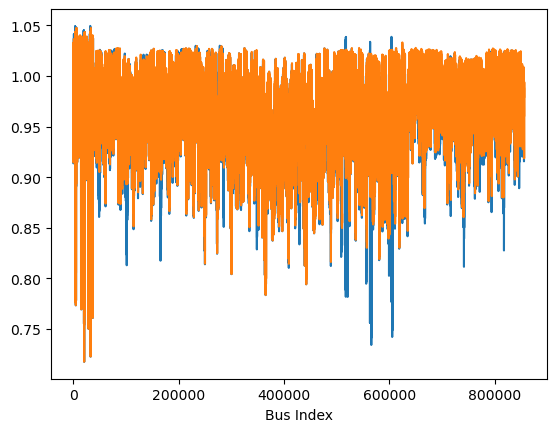

In [40]:
# a = (np.array(list(vpu_allbus.values()))-np.array(list(vpu_allbus_o.values())))
plt.plot(np.array(list(vpu_allbus.values())))
plt.plot(np.array(list(vpu_allbus_o.values())))
plt.xlabel('Bus Index')